In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string],'')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
# data를 받아옴

train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
# NUM_EPOCHS = 2
NUM_EPOCHS = 10  # 어차피 early stopping 시킬거니까 10번 주자
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,   # 단어 하나당 128 차원
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension': 1}

# 여기까지 하면 classifier 정리 끝

In [7]:
# 레이어 선언, 레이어 쌓기
# 책 p199에선 region sizes가 234지만, 여기선 345로 할 것
# 책에선 5차원, 여기선 단어 하나당 128 차원  (?)
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'] + 1,
                                         output_dim=kargs['embedding_size'] )
        # 커널싱즈 3.4.5개로
        self.conv_list =[layers.Conv1D(filters=kargs['num_filters'],  #출력개수
                                       kernel_size=kernel_size,
                                       padding='valid',
                                       activation='relu',
                                       kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))  # 제약을 줌 ->
                         # 커널을 생성할때, 가중치값을 3을 못넘게 -> MaxNorm값을 줌 -> 스케일이 이 이상 커짖 ㅣ않게 제약을 준 것
                         for kernel_size in [3, 4, 5]]
        self.pooling = layers.GlobalMaxPooling1D()
        # 지가 알아서 큰 사이즈 전체(?) 입력값으로 받겠다.
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                                activation='relu',
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation='sigmoid',
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):   # call 함수 생성.  call만 만들면 됨
        x = self.embedding(x)
        x = self.dropout(x)
        # p199 에서 출력을 각각 maxpooling하고 붙임 그걸 다음과 같은 문법으로 나타냄
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)  # inerconfresion 문법?
        # conv를 각각 넣어서 list로 만들고 그것을 concat함.  axis = -1방향으로
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [8]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [9]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_en -- Folder already exists 



In [10]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
44/44 [==============================] - 6s 54ms/step - loss: 0.6709 - accuracy: 0.5960 - val_loss: 0.5596 - val_accuracy: 0.7752

Epoch 00001: val_accuracy improved from -inf to 0.77520, saving model to ./data_out/cnn_classifier_en\weights.h5
Epoch 2/10
44/44 [==============================] - 2s 42ms/step - loss: 0.3789 - accuracy: 0.8404 - val_loss: 0.3088 - val_accuracy: 0.8768

Epoch 00002: val_accuracy improved from 0.77520 to 0.87680, saving model to ./data_out/cnn_classifier_en\weights.h5
Epoch 3/10
44/44 [==============================] - 2s 42ms/step - loss: 0.2129 - accuracy: 0.9187 - val_loss: 0.2915 - val_accuracy: 0.8880

Epoch 00003: val_accuracy improved from 0.87680 to 0.88800, saving model to ./data_out/cnn_classifier_en\weights.h5
Epoch 4/10
44/44 [==============================] - 2s 43ms/step - loss: 0.1280 - accuracy: 0.9543 - val_loss: 0.3290 - val_accuracy: 0.8780

Epoch 00004: val_accuracy did not improve from 0.88800
Epoch 5/10
44/44 [==============

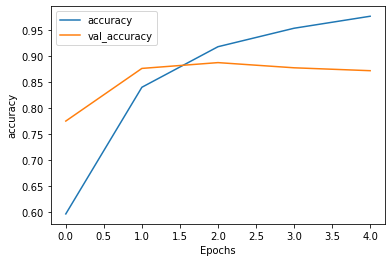

In [11]:
plot_graphs(history, 'accuracy')

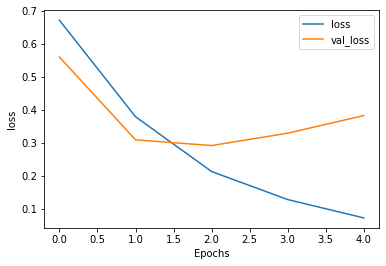

In [12]:
plot_graphs(history, 'loss')